In [2]:
import time
import numpy as np
import networkx as nx
from utils.dotdict import dotdict
import matplotlib.pyplot as plt
from numba import jit

import itertools
import multiprocessing

from utils.graph_generator import get_graph

from scripts.awareness.agent_country import Agent_Country

args = dotdict({
    "logfile": "/tmp/temp.log",
    "plot": False,
    "max_iteration": 1000,
    "beta_super":0.0,
    "xi": 1,
    "p_teleport":0.0,
    "MAX_E_TIME":10,
    "MAX_I_TIME":10,
    "super_infected_agents": [],
    "p_super": 0.0,
    "awM": None,
    "awR": -1,
    "random_seed":0,
    "CPU_cores":2,
    "simnum":10,
})


In [3]:
def run(args, beta, gamma, n, awM, callback = None):
    args = dotdict(args)
    graph = get_graph("grid", {"n": n*n, "N": -1, "d": 4})
    args["I_time"]=int(1/gamma)
    args["infected_agents"]=[n//2+(n//2)*n]
    args["beta"]=beta
    args["gamma"]=gamma
    args["awM"] = awM

    country = Agent_Country(args, graph)
    history,merged = country.run_fast(0, args.infected_agents, simnum=args["simnum"], callback=callback)
    """
    history = np.zeros(shape = (args["simnum"], args["max_iteration"], 4))
    for it in range(args["simnum"]):
        country = Agent_Country(args, graph)
        Agent_Country.numba_random_seed(it)
        for step in range(args["max_iteration"]):
            history[it,step,2]=np.sum(country.states==2)
            if country.check_stop():
                #break
                pass
            country.step()
    """
    return history

def multi_run(args, betas, gammas, ns, awMs, callback):
    temp_res = {}
    pool = multiprocessing.Pool(processes=args.CPU_cores)

    for (beta, gamma), n, awM in itertools.product(zip(betas, gammas), ns, awMs):
        temp_res[(beta, gamma, n, awM)]=pool.apply_async(run, args=(dict(args), beta, gamma, n, awM, callback))

    pool.close()
    pool.join()

    res = {}
    for params, hist in temp_res.items():
        res[params] = hist.get()

    return res

def measure1(betas, gammas, ns, awMs, xs, plot_args):
    @jit(nopython=True)
    def get_mean(hist, max_iter):
        res = np.zeros(len(hist))
        for i in range(len(hist)):
            res[i]=np.mean(hist[i,max_iter//2:,2])
        return res

    res = multi_run(args, betas, gammas, ns, awMs, get_mean)

    
    res_y = {p: np.mean(hist) for p,hist in res.items()}
    res_err = {p: np.std(hist) for p,hist in res.items()}
    #res_y = {p: np.mean(hist[:,args.max_iteration//2:,2], axis=(0,1), keepdims=False) for p,hist in res.items()}
    #res_err = {p: np.std(np.mean(hist[:,args.max_iteration//2:,2], axis=1, keepdims=True), axis=(0,1), keepdims=False) for p,hist in res.items()}

    ys = [res_y[(beta,gamma,n,awM)] for (beta,gamma),n,awM in itertools.product(zip(betas,gammas),ns,awMs)]
    y_err = [res_err[(beta,gamma,n,awM)] for (beta,gamma),n,awM in itertools.product(zip(betas,gammas),ns,awMs)]

    
    # === Plot ===
    xs = np.array(xs)
    if("limits" not in plot_args):
        a,b = None, None
    else:
        a,b = plot_args["limits"]
    plt.errorbar(xs,ys, yerr=y_err)
    plt.title(plot_args["title"])
    plt.xlabel(plot_args["xlabel"])
    plt.ylabel(plot_args["ylabel"])
    
    xs,ys = xs[a:b],ys[a:b]
    sl, inter = np.polyfit(xs,ys, 1)
    ys = xs*sl+inter
    plt.plot(xs, ys, label = "lin approx", c="r")
    plt.legend(["slope {:.3f} intercept {:.3f}".format(sl, inter)])

    return ys, y_err


In [4]:
@jit(nopython=True)
def mymean(hist, max_iter):
    res = np.zeros(len(hist))
    for i in range(len(hist)):
        res[i]=np.mean(hist[i,max_iter//2:,2])
    return res

arr = run(args, 0.5, 0.25, 10, 0.1, mymean)
print(np.shape(arr))
arr

(10,)


array([18.344, 18.23 , 18.164, 18.518, 17.81 , 18.112, 17.422, 18.634,
       18.114, 18.56 ])

# Measure 1

* The std is computed after we take the mean in each run

Measure 1.4 done


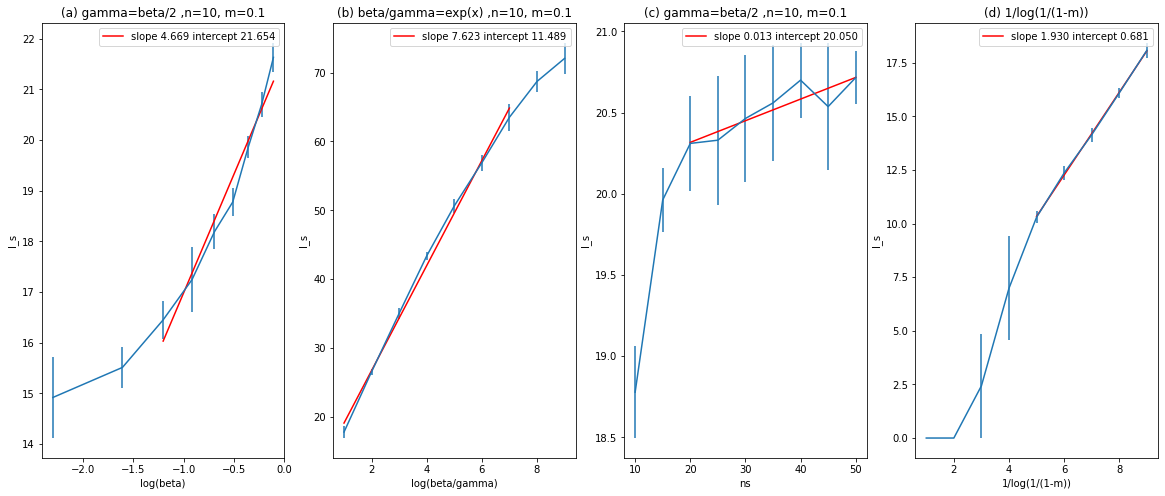

CPU times: user 694 ms, sys: 521 ms, total: 1.22 s
Wall time: 14 s


In [4]:
%%time

plt.figure(figsize=(20,8))
plt.subplot(1,4,1)
# === 1 ===
betas = np.array(range(1,10))/10
gammas = betas/2

measure1(betas, gammas, [10], [0.1],
        xs = np.log(betas),
        plot_args={
            "xlabel":"log(beta)",
            "ylabel":"I_s",
            "title":"(a) gamma=beta/2 ,n=10, m=0.1",
            "limits":(2,None)})


# === 2 ===
plt.subplot(1,4,2)
betas = np.array(range(1,10))/10
gb=list(map(lambda x: np.exp(x), range(1,10))) 
gammas = betas/np.array(gb)

measure1(betas, gammas, [10], [0.1],
        xs = np.log(betas/gammas),
        plot_args={
            "xlabel":"log(beta/gamma)",
            "ylabel":"I_s",
            "title":"(b) beta/gamma=exp(x) ,n=10, m=0.1", "limits":(None,-2)})


# === 3 ===
plt.subplot(1,4,3)
ns = [10,15,20,25,30,35, 40, 45, 50]

measure1([0.6], [0.3], ns, [0.1],
        xs = ns,
        plot_args={
            "xlabel":"ns",
            "ylabel":"I_s",
            "title":"(c) gamma=beta/2 ,n=10, m=0.1", "limits":(2,None)})

# === 4 ===
plt.subplot(1,4,4)
awMs = [1-np.exp(-1/x) for x in range(1,10)]
measure1([0.6], [0.3], [10], awMs,
        xs = np.log(betas/gammas),
        plot_args={
            "xlabel":"1/log(1/(1-m))",
            "ylabel":"I_s",
            "title":"(d) 1/log(1/(1-m))",
            "limits":(4,None)})
print("Measure 1.4 done")
plt.show()

In [5]:
betas = np.array(range(1,10))/10
gb=list(map(lambda x: np.exp(x), range(1,10))) 
gammas = betas/np.array(gb)

print(betas/gammas)

[2.71828183e+00 7.38905610e+00 2.00855369e+01 5.45981500e+01
 1.48413159e+02 4.03428793e+02 1.09663316e+03 2.98095799e+03
 8.10308393e+03]


## Larger sizes (n=100)

### Maximum size: n=200
* There are problems with the memory allocation of the dist_bfs

Measure 1.1 done
Measure 1.2 done
Measure 1.3 done
Measure 1.4 done


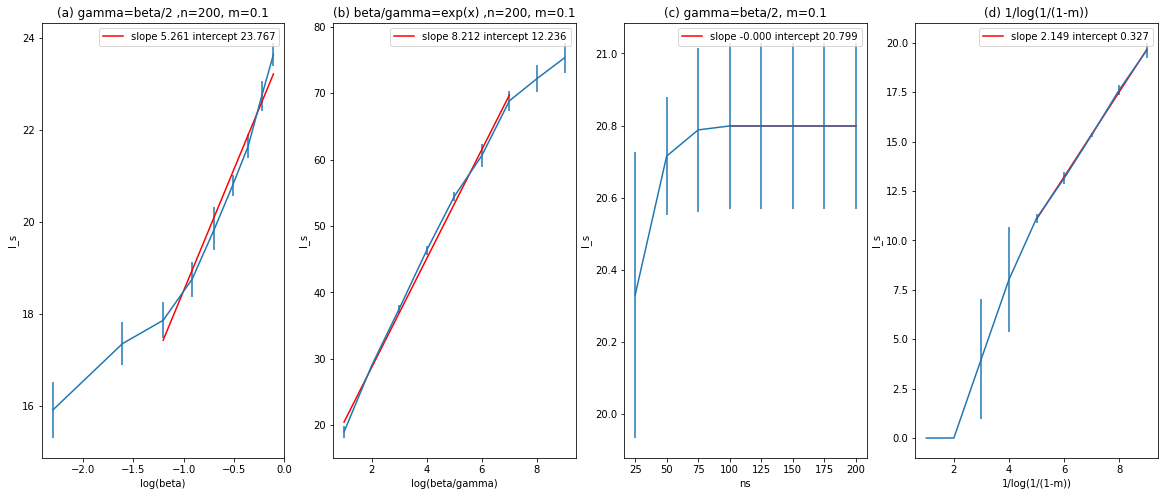

CPU times: user 719 ms, sys: 453 ms, total: 1.17 s
Wall time: 50.7 s


In [6]:
%%time

plt.figure(figsize=(20,8))
plt.subplot(1,4,1)
# === 1 ===
betas = np.array(range(1,10))/10
gammas = betas/2

measure1(betas, gammas, [200], [0.1],
        xs = np.log(betas),
        plot_args={
            "xlabel":"log(beta)",
            "ylabel":"I_s",
            "title":"(a) gamma=beta/2 ,n=200, m=0.1",
            "limits":(2,None)})
print("Measure 1.1 done")

# === 2 ===
plt.subplot(1,4,2)
betas = np.array(range(1,10))/10
gb=list(map(lambda x: np.exp(x), range(1,10))) 
gammas = betas/np.array(gb)

measure1(betas, gammas, [200], [0.1],
        xs = np.log(betas/gammas),
        plot_args={
            "xlabel":"log(beta/gamma)",
            "ylabel":"I_s",
            "title":"(b) beta/gamma=exp(x) ,n=200, m=0.1",
            "limits":(None,-2)})
print("Measure 1.2 done")

# === 3 ===
plt.subplot(1,4,3)
ns = [25,50,75,100,125,150,175,200]

measure1([0.6], [0.3], ns, [0.1],
        xs = ns,
        plot_args={
            "xlabel":"ns",
            "ylabel":"I_s",
            "title":"(c) gamma=beta/2, m=0.1",
            "limits":(3,None)})
print("Measure 1.3 done")

# === 4 ===
plt.subplot(1,4,4)
awMs = [1-np.exp(-1/x) for x in range(1,10)]
measure1([0.6], [0.3], [200], awMs,
        xs = np.log(betas/gammas),
        plot_args={
            "xlabel":"1/log(1/(1-m))",
            "ylabel":"I_s",
            "title":"(d) 1/log(1/(1-m))",
            "limits":(4,None)})
print("Measure 1.4 done")
plt.show()

\begin{align}
 I &= \frac{\log\left(\frac{\gamma}{\beta c_g}\right)}{\log(1-m)} = \frac{\log\left(c_g\frac{\beta}{\gamma}\right)}{\log\left(\frac{1}{1-m}\right)}
\end{align}


* From (a) $I_s$ depends only on $\beta / \gamma$ ???

* From the slope of plot (b) we should have ($\beta = 0$, hence the equation)
$$\frac{1}{\log\left(\frac{1}{1-m}\right)} \approx 9.49 (simulation: 8.12)$$

* On figure (c) we can see, that $I_s$ is independent of the graph size

* From the slope of plot (d) we should have
$$\log\left(c_g \frac{\beta}{\gamma}\right) = \frac{I_s}{1/\log\left(\frac{1}{1-m}\right)} \approx 2.159 \Rightarrow c_g \approx \frac{e^{2.159}}{2}\approx 4.33$$

* From the intercept of plot (d) we should have
$$\frac{\log\left(c_g\right)}{\log\left(\frac{1}{1-m}\right)} \approx 13.91 (!!!) $$ 

In [52]:
a = 1/np.log(1/(1-0.1))
print(a)

b = np.exp(2.159)/2
print(b)

c = np.log(b)/(np.log(1/(1-0.1)))
print(c)



9.4912215810299
4.331235427464495
13.912733914482967


# Random regular graphs

In [5]:
def run(args, beta, gamma, n, awM, callback = None):
    args = dotdict(args)
    graph = get_graph("random-regular", {"n": n*n, "N": -1, "d": 4})
    args["I_time"]=int(1/gamma)
    args["infected_agents"]=[n//2+(n//2)*n]
    args["beta"]=beta
    args["gamma"]=gamma
    args["awM"] = awM

    country = Agent_Country(args, graph)
    history,merged = country.run_fast(0, args.infected_agents, simnum=args["simnum"], callback=callback)
    return history

CPU times: user 175 ms, sys: 31.1 ms, total: 206 ms
Wall time: 12.9 s


(array([ 67.15586373,  68.14722115,  69.13857857,  70.12993599,
         71.12129341,  72.11265083,  73.10400825,  74.09536567,
         75.08672309,  76.07808051,  77.06943793,  78.06079535,
         79.05215277,  80.04351019,  81.03486761,  82.02622504,
         83.01758246,  84.00893988,  85.0002973 ,  85.99165472,
         86.98301214,  87.97436956,  88.96572698,  89.9570844 ,
         90.94844182,  91.93979924,  92.93115666,  93.92251408,
         94.9138715 ,  95.90522892,  96.89658634,  97.88794376,
         98.87930119,  99.87065861, 100.86201603, 101.85337345,
        102.84473087]),
 [0.8915915881164429,
  0.8083827063959227,
  23.794888479671428,
  36.81813357789881,
  37.17283137776836,
  32.96860804826312,
  33.244542466997494,
  25.127127186369716,
  25.417334765077157,
  25.67299122424187,
  25.878629132162313,
  26.05718679827122,
  26.256686109256055,
  0.37314603039560756,
  0.20248664153469545,
  26.890704874361326,
  27.089329689750535,
  27.240104328728258,
  27.38

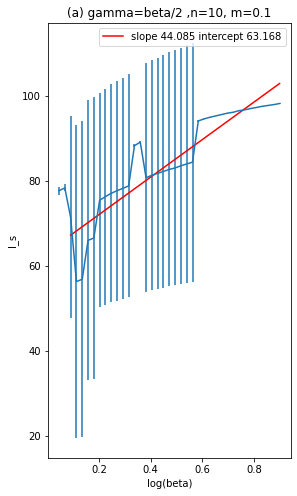

In [15]:
%%time

args["MAX_I_TIME"]=100
args["max_iteration"]=1000
plt.figure(figsize=(20,8))
plt.subplot(1,4,1)
# === 1 ===
#betas = np.array(range(1,10))/10
betas = np.linspace(0.023,0.9,40)[1:]
gammas = betas/1.1

measure1(betas, gammas, [10], [0.0],
        xs = betas,
        plot_args={
            "xlabel":"log(beta)",
            "ylabel":"I_s",
            "title":"(a) gamma=beta/2 ,n=10, m=0.1",
            "limits":(2,None)})


In [13]:
betas/gammas

array([1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2,
       1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2,
       1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2])

Measure 1.4 done


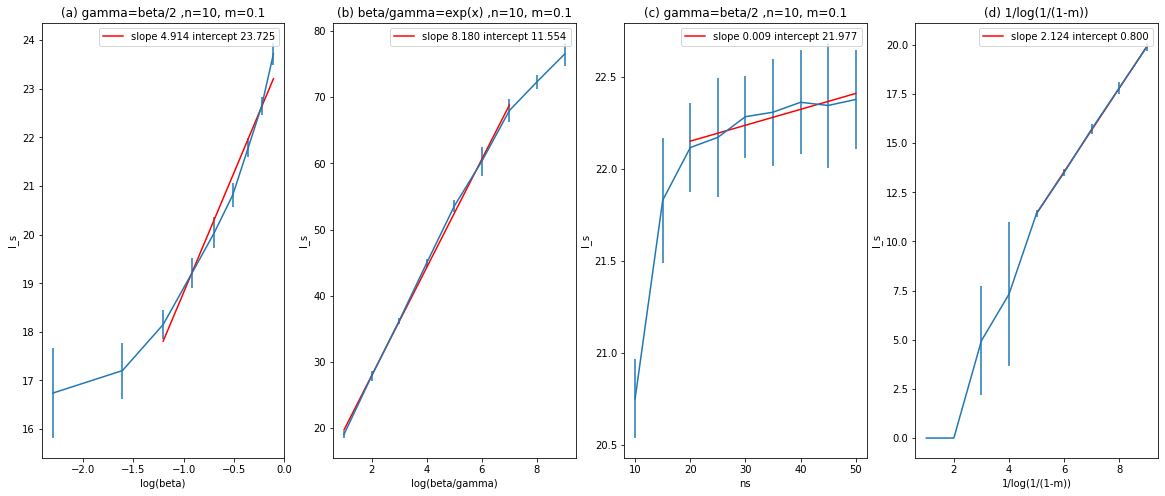

CPU times: user 714 ms, sys: 599 ms, total: 1.31 s
Wall time: 45.5 s


In [8]:
%%time

plt.figure(figsize=(20,8))
plt.subplot(1,4,1)
# === 1 ===
betas = np.array(range(1,10))/10
gammas = betas/2

measure1(betas, gammas, [10], [0.1],
        xs = np.log(betas),
        plot_args={
            "xlabel":"log(beta)",
            "ylabel":"I_s",
            "title":"(a) gamma=beta/2 ,n=10, m=0.1",
            "limits":(2,None)})


# === 2 ===
plt.subplot(1,4,2)
betas = np.array(range(1,10))/10
gb=list(map(lambda x: np.exp(x), range(1,10))) 
gammas = betas/np.array(gb)

measure1(betas, gammas, [10], [0.1],
        xs = np.log(betas/gammas),
        plot_args={
            "xlabel":"log(beta/gamma)",
            "ylabel":"I_s",
            "title":"(b) beta/gamma=exp(x) ,n=10, m=0.1", "limits":(None,-2)})


# === 3 ===
plt.subplot(1,4,3)
ns = [10,15,20,25,30,35, 40, 45, 50]

measure1([0.6], [0.3], ns, [0.1],
        xs = ns,
        plot_args={
            "xlabel":"ns",
            "ylabel":"I_s",
            "title":"(c) gamma=beta/2 ,n=10, m=0.1", "limits":(2,None)})

# === 4 ===
plt.subplot(1,4,4)
awMs = [1-np.exp(-1/x) for x in range(1,10)]
measure1([0.6], [0.3], [10], awMs,
        xs = np.log(betas/gammas),
        plot_args={
            "xlabel":"1/log(1/(1-m))",
            "ylabel":"I_s",
            "title":"(d) 1/log(1/(1-m))",
            "limits":(4,None)})
print("Measure 1.4 done")
plt.show()

## Larger sizes

Measure 1.1 done
Measure 1.2 done
Measure 1.3 done
Measure 1.4 done


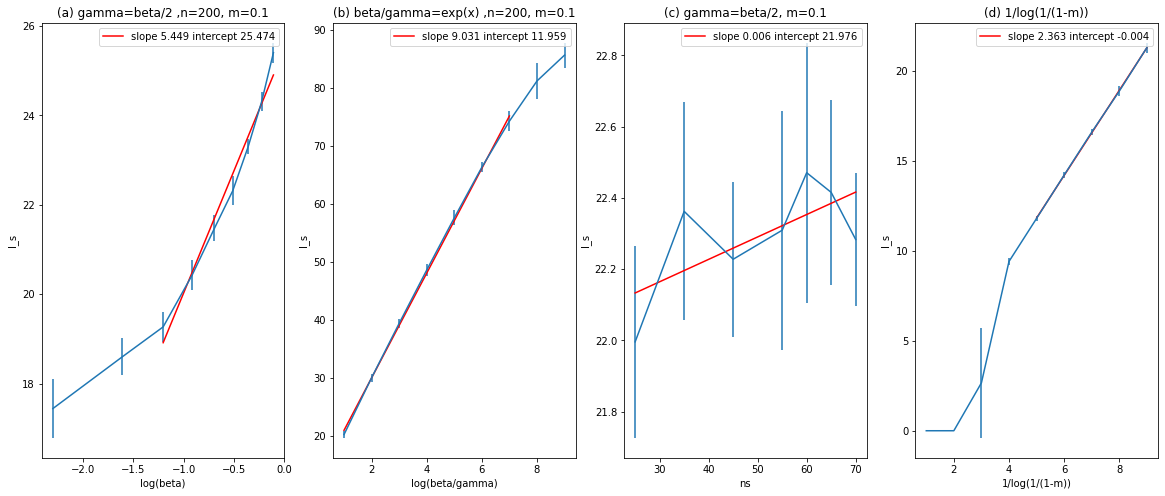

CPU times: user 584 ms, sys: 620 ms, total: 1.2 s
Wall time: 6min 41s


In [9]:
%%time

plt.figure(figsize=(20,8))
plt.subplot(1,4,1)
# === 1 ===
betas = np.array(range(1,10))/10
gammas = betas/2

measure1(betas, gammas, [50], [0.1],
        xs = np.log(betas),
        plot_args={
            "xlabel":"log(beta)",
            "ylabel":"I_s",
            "title":"(a) gamma=beta/2 ,n=200, m=0.1",
            "limits":(2,None)})
print("Measure 1.1 done")

# === 2 ===
plt.subplot(1,4,2)
betas = np.array(range(1,10))/10
gb=list(map(lambda x: np.exp(x), range(1,10))) 
gammas = betas/np.array(gb)

measure1(betas, gammas, [50], [0.1],
        xs = np.log(betas/gammas),
        plot_args={
            "xlabel":"log(beta/gamma)",
            "ylabel":"I_s",
            "title":"(b) beta/gamma=exp(x) ,n=200, m=0.1",
            "limits":(None,-2)})
print("Measure 1.2 done")

# === 3 ===
plt.subplot(1,4,3)
ns = [25,35,45,55,60,65,70]

measure1([0.6], [0.3], ns, [0.1],
        xs = ns,
        plot_args={
            "xlabel":"ns",
            "ylabel":"I_s",
            "title":"(c) gamma=beta/2, m=0.1",
            "limits":(None,None)})
print("Measure 1.3 done")

# === 4 ===
plt.subplot(1,4,4)
awMs = [1-np.exp(-1/x) for x in range(1,10)]
measure1([0.6], [0.3], [50], awMs,
        xs = np.log(betas/gammas),
        plot_args={
            "xlabel":"1/log(1/(1-m))",
            "ylabel":"I_s",
            "title":"(d) 1/log(1/(1-m))",
            "limits":(4,None)})
print("Measure 1.4 done")
plt.show()

# Two infections:

In [47]:
def run(args, beta, gamma, n, awM, callback = None):
    args = dotdict(args)
    graph = get_graph("grid", {"n": n*n, "N": -1, "d": 4})
    args["I_time"]=int(1/gamma)
    args["infected_agents"] = [3,n*n-4]
    args["beta"]=beta
    args["gamma"]=gamma
    args["awM"] = awM

    country = Agent_Country(args, graph)
    history,merged = country.run_fast(0, args.infected_agents, simnum=args["simnum"], callback=callback)

    return merged

def measure2(betas, gammas, ns, awMs):
    @jit(nopython=True)
    def chill(hist, max_iter):
        return hist
        
    res = multi_run(args, betas, gammas, ns, awMs, chill)
    
    img = np.zeros(shape=(len(ns),len(awMs)))
    for i,n in enumerate(ns):
        for j,m in enumerate(awMs):
            img[i,j] = res[(betas[0], gammas[0], n, m)]
    
    plt.imshow(img, aspect='auto', origin="lower", extent=[min(awMs),max(awMs),min(ns),max(ns)])
    plt.ylabel("n")
    ax = plt.gca()
    plt.xlabel("m")
    plt.title("beta="+str(betas[0]) +", gamma="+str(gammas[0]))
    plt.colorbar()

0.3 0.2 done


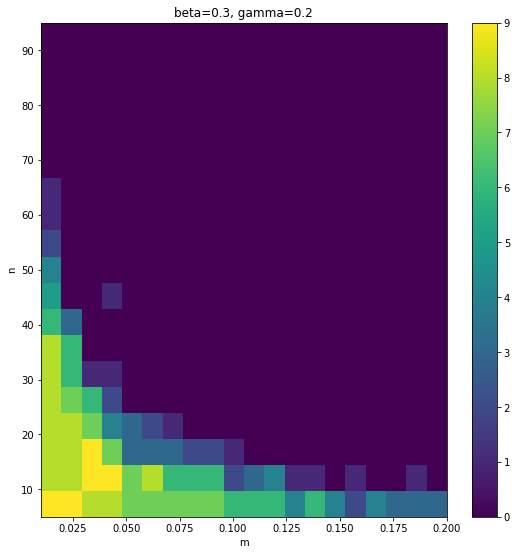

0.75 0.5 done


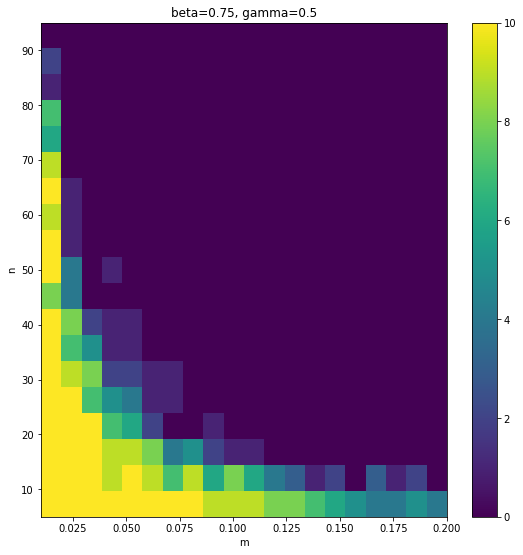

0.75 0.2 done


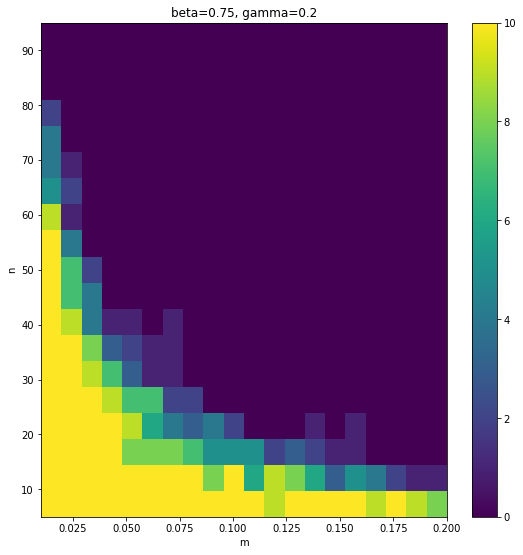

0.6 0.5 done


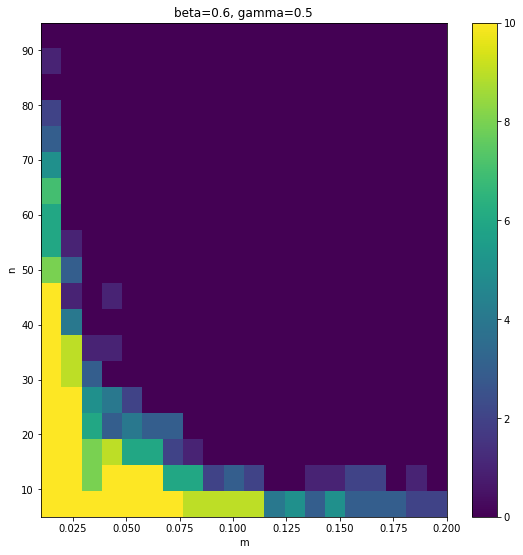

In [51]:
betas = [0.3,0.75,0.75,0.6]
gammas = [0.2,0.5,0.2,0.5]
ns = np.arange(5,100,5)
max_infs = np.linspace(0.01, 0.2, 20)


for i,(beta,gamma) in enumerate(zip(betas, gammas)):
    plt.figure(figsize=(20,20))
    plt.subplot(2,2,i+1)
    measure2([beta], [gamma], ns, max_infs)
    print(beta, gamma, "done")
    plt.show()

In [ ]:
args["simnum"] = 100
betas = [0.3,0.75,0.75,0.6]
gammas = [0.2,0.5,0.2,0.5]
ns = np.arange(5,100,5)

fig,axs = plt.subplots(2, 2, figsize=(20,20))
fig.tight_layout()

for i,(beta,gamma) in enumerate(zip(betas, gammas)):
    plt.figure(figsize=(20,20))
    plt.subplot(2,2,i+1)
    
    max_infs = list(map(lambda x: 1-(2.66*beta/gamma)**(-1/x), np.array(range(1,20))*4))
    measure2([beta], [gamma], ns, max_infs)
    print(beta, gamma, "done")
    plt.show()